>>> [Test Cell 03 - Phiên bản Log(y)] Bắt đầu chạy...
[Cell] Đang thiết lập cấu hình...
Đường dẫn file dữ liệu: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\data\processed\dataset_clean.csv
[Cell] Đang định nghĩa các Hàm và Lớp...
[Cell] Đang định nghĩa Lớp CustomMLPRegressor (Nâng cấp Huber Loss)...
[Cell] Đang định nghĩa hàm đánh giá...

[Cell] Đang tải và chuẩn bị dữ liệu (Robust(X) + Log(y))...
Đang tải dữ liệu đã xử lý từ: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\data\processed\dataset_clean.csv
Đang áp dụng RobustScaler cho X...
Đang áp dụng Log Transform (np.log1p) cho y...
Chuẩn bị dữ liệu hoàn tất.

[Cell] Đang huấn luyện: 1. Custom MLP (Full Features - Thử nghiệm Huber Loss)...
[EarlyStopping] Tách 10.0% dữ liệu làm validation (patience=50).
Bắt đầu huấn luyện Custom MLP (Huber Loss, delta=1.0, L2=0.01) với 5000 epochs (batch_size=64)...
Số mẫu huấn luyện: 712
Epoch 1/5000, Train Cost (Huber): 1.009835, Val Cost (Huber): 0.674292
Ep

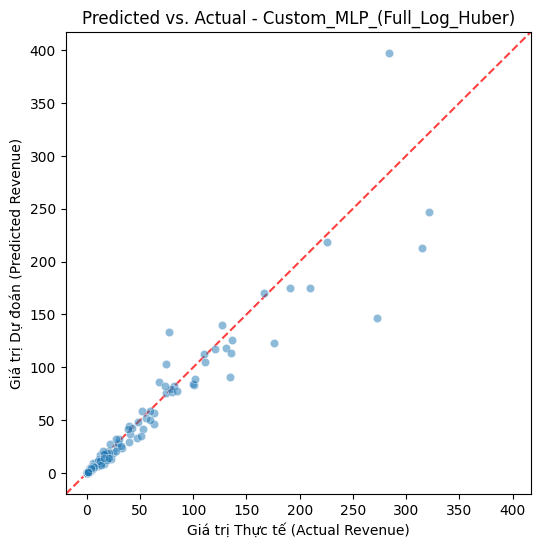


[Cell] Đang huấn luyện: 2. Custom MLP (PCA Features - Thử nghiệm Log Transform)...
PCA: Đã giảm từ 13 xuống 2 chiều.
[EarlyStopping] Tách 10.0% dữ liệu làm validation (patience=50).
Bắt đầu huấn luyện Custom MLP (Huber Loss, delta=1.0, L2=0.01) với 5000 epochs (batch_size=64)...
Số mẫu huấn luyện: 712

--- EARLY STOPPING KÍCH HOẠT ---
Epoch 252: Validation loss không cải thiện trong 50 epochs.
Hoàn tất huấn luyện. Loss tốt nhất: 0.078905
Khôi phục trọng số từ epoch có val_loss tốt nhất (0.078905).

------------------------------
KẾT QUẢ ĐÁNH GIÁ CHO: Custom_MLP_(PCA_Log)
R-Squared (R²): -1.7574
Mean Absolute Error (MAE): 11.4311
Mean Squared Error (MSE): 5742.6517
Root Mean Squared Error (RMSE): 75.7803
------------------------------
Đã lưu biểu đồ phân tán tại: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\reports\figures\scatter_custom_mlp_(pca_log).png


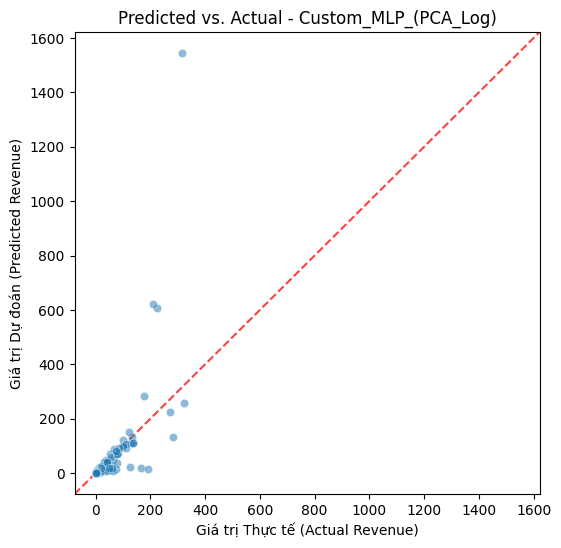


[Cell] HOÀN TẤT: Lưu kết quả ra file JSON...
Đã lưu kết quả của Custom MLP tại: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\reports\results\mlp_test_results.json

Bảng kết quả tổng hợp (Custom MLP):


,Model,Features,R-Squared,MAE,MSE,RMSE
0,Custom MLP,Full,0.916173,3.278501,174.582382,13.212963
1,Custom MLP,PCA,-1.757360,11.431059,5742.651722,75.780286



>>> [Test Cell 03] Đã chạy xong.


In [4]:
# %%
print(">>> [Test Cell 03 - Phiên bản Log(y)] Bắt đầu chạy...")

import pandas as pd
import numpy as np
import os
import sys
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler  # <<< Dùng cho X
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import copy

# --- Bỏ qua các cảnh báo (cho gọn) ---
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# %%
print("[Cell] Đang thiết lập cấu hình...")

try:
    CURRENT_DIR = os.getcwd() 
    ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
    
    PROCESSED_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_clean.csv')
    REPORTS_DIR = os.path.join(ROOT_DIR, 'reports')
    FIGURES_DIR = os.path.join(REPORTS_DIR, 'figures')
    RESULTS_DIR = os.path.join(REPORTS_DIR, 'results')
    
    RANDOM_STATE = 42
    TEST_SIZE = 0.3
    
    print(f"Đường dẫn file dữ liệu: {PROCESSED_DATA_PATH}")

except Exception as e:
    print(f"Lỗi khi thiết lập đường dẫn: {e}")

# %%
print("[Cell] Đang định nghĩa các Hàm và Lớp...")

# --- Hàm kích hoạt ---
def leaky_relu(Z, alpha=0.01):
    return np.maximum(alpha * Z, Z)

def leaky_relu_derivative(Z, alpha=0.01):
    dZ = np.ones_like(Z)
    dZ[Z < 0] = alpha
    return dZ

def linear(Z):
    return Z

def linear_derivative(Z):
    return np.ones_like(Z)

# --- Hàm PCA (Bắt buộc) ---
def apply_pca(X_train, X_test, n_components=0.95):
    """
    Áp dụng PCA để giảm chiều dữ liệu.
    """
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    print(f"PCA: Đã giảm từ {X_train.shape[1]} xuống {pca.n_components_} chiều.")
    return X_train_pca, X_test_pca

# --- Lớp Custom MLP Regressor (Bản đầy đủ) ---
# %%
print("[Cell] Đang định nghĩa Lớp CustomMLPRegressor (Nâng cấp Huber Loss)...")

# (Các hàm leaky_relu, linear... và apply_pca giữ nguyên như trước)

# --- Lớp Custom MLP Regressor (Bản Nâng Cấp: Huber Loss) ---
class CustomMLPRegressor:
    """
    MLPRegressor cho Hồi quy (Nâng cấp)
    - Optimizer: Adam
    - Regularization: Early Stopping + L2
    - Activation: Leaky ReLU
    - Initialization: He
    - === LOSS FUNCTION: HUBER LOSS ===
    """
    
    def __init__(self, layer_dims, learning_rate=0.001, epochs=2000, batch_size=32,
                 beta1=0.9, beta2=0.999, epsilon=1e-8, 
                 lambd=0.0, alpha=0.01, 
                 delta=1.0, # <<< ### CẢI TIẾN MỚI: Ngưỡng Huber Loss ###
                 early_stopping=True, patience=20, validation_fraction=0.1,
                 random_state=42):
        
        np.random.seed(random_state)
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.lambd = lambd
        self.alpha = alpha
        
        # --- ### CẢI TIẾN: Lưu tham số Huber Loss ### ---
        self.delta = delta 
        
        self.early_stopping = early_stopping
        self.patience = patience
        self.validation_fraction = validation_fraction

        self.parameters = {}
        self.costs = []
        self.val_costs = []
        self.m = {} 
        self.s = {} 
        self.t = 0  
        
        for l in range(1, len(self.layer_dims)):
            input_dim = self.layer_dims[l-1]
            output_dim = self.layer_dims[l]
            
            self.parameters[f'W{l}'] = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim) 
            self.parameters[f'b{l}'] = np.zeros((1, output_dim))
            
            self.m[f'dW{l}'] = np.zeros_like(self.parameters[f'W{l}'])
            self.m[f'db{l}'] = np.zeros_like(self.parameters[f'b{l}'])
            self.s[f'dW{l}'] = np.zeros_like(self.parameters[f'W{l}'])
            self.s[f'db{l}'] = np.zeros_like(self.parameters[f'b{l}'])

    # --- ### CẢI TIẾN: HÀM HUBER LOSS ### ---
    def _compute_loss(self, A_last, Y):
        m = Y.shape[0]
        if m == 0:
            return 0.0
        
        residual = A_last - Y
        abs_residual = np.abs(residual)
        
        # Tính Huber Loss
        # 1. Phần MSE (sai số nhỏ)
        mse_part = (abs_residual <= self.delta) * 0.5 * np.square(residual)
        # 2. Phần MAE (sai số lớn)
        mae_part = (abs_residual > self.delta) * (self.delta * abs_residual - 0.5 * np.square(self.delta))
        
        huber_cost = (1 / m) * np.sum(mse_part + mae_part)
        
        # Tính L2 Cost (giữ nguyên)
        l2_cost = 0.0
        if self.lambd > 0:
            L = len(self.layer_dims) - 1
            for l in range(1, L + 1):
                l2_cost += np.sum(np.square(self.parameters[f'W{l}']))
        
        total_cost = huber_cost + (self.lambd / (2 * m)) * l2_cost
        return np.squeeze(total_cost)

    def _feedforward(self, X):
        # (Hàm này giữ nguyên, không thay đổi)
        cache = {'A0': X}
        A = X
        L = len(self.layer_dims) - 1
        for l in range(1, L):
            Z = np.dot(A, self.parameters[f'W{l}']) + self.parameters[f'b{l}']
            A = leaky_relu(Z, self.alpha)
            cache[f'Z{l}'] = Z
            cache[f'A{l}'] = A
        ZL = np.dot(A, self.parameters[f'W{L}']) + self.parameters[f'b{L}']
        A_last = linear(ZL) 
        cache[f'Z{L}'] = ZL
        cache[f'A{L}'] = A_last
        return A_last, cache

    # --- ### CẢI TIẾN: ĐẠO HÀM HUBER LOSS ### ---
    def _backpropagate(self, A_last, Y, cache):
        gradients = {}
        m = Y.shape[0]
        L = len(self.layer_dims) - 1
        Y = Y.reshape(A_last.shape)

        # Lớp Output (L) (Linear + Huber Loss)
        residual = A_last - Y
        
        # Đạo hàm của Huber Loss:
        # - Nếu |residual| <= delta, đạo hàm là 'residual' (giống MSE)
        # - Nếu residual > delta, đạo hàm là 'delta'
        # - Nếu residual < -delta, đạo hàm là '-delta'
        # Chúng ta dùng np.clip để làm việc này:
        dZ_last = np.clip(residual, a_min=-self.delta, a_max=self.delta)
        
        A_prev = cache[f'A{L-1}']
        
        l2_grad_W_L = (self.lambd / m) * self.parameters[f'W{L}']
        gradients[f'dW{L}'] = (1/m) * np.dot(A_prev.T, dZ_last) + l2_grad_W_L
        gradients[f'db{L}'] = (1/m) * np.sum(dZ_last, axis=0, keepdims=True)
        dA_prev = np.dot(dZ_last, self.parameters[f'W{L}'].T)

        # Lớp Ẩn (L-1 đến 1) (Giữ nguyên)
        for l in reversed(range(1, L)):
            Z = cache[f'Z{l}']
            dZ = dA_prev * leaky_relu_derivative(Z, self.alpha)
            A_prev = cache[f'A{l-1}']
            
            l2_grad_W_l = (self.lambd / m) * self.parameters[f'W{l}']
            gradients[f'dW{l}'] = (1/m) * np.dot(A_prev.T, dZ) + l2_grad_W_l
            gradients[f'db{l}'] = (1/m) * np.sum(dZ, axis=0, keepdims=True)
            
            if l > 1:
                dA_prev = np.dot(dZ, self.parameters[f'W{l}'].T)
                
        return gradients

    # --- (Hàm _update_weights_adam và fit giữ nguyên) ---
    
    def _update_weights_adam(self, gradients):
        # (Không thay đổi)
        self.t += 1 
        L = len(self.layer_dims) - 1
        for l in range(1, L + 1):
            W_key, b_key = f'W{l}', f'b{l}'
            dW_key, db_key = f'dW{l}', f'db{l}'
            self.m[dW_key] = self.beta1 * self.m[dW_key] + (1 - self.beta1) * gradients[dW_key]
            self.s[dW_key] = self.beta2 * self.s[dW_key] + (1 - self.beta2) * np.square(gradients[dW_key])
            m_corrected = self.m[dW_key] / (1 - self.beta1**self.t)
            s_corrected = self.s[dW_key] / (1 - self.beta2**self.t)
            self.parameters[W_key] -= self.learning_rate * m_corrected / (np.sqrt(s_corrected) + self.epsilon)
            self.m[db_key] = self.beta1 * self.m[db_key] + (1 - self.beta1) * gradients[db_key]
            self.s[db_key] = self.beta2 * self.s[db_key] + (1 - self.beta2) * np.square(gradients[db_key])
            m_b_corrected = self.m[db_key] / (1 - self.beta1**self.t)
            s_b_corrected = self.s[db_key] / (1 - self.beta2**self.t)
            self.parameters[b_key] -= self.learning_rate * m_b_corrected / (np.sqrt(s_b_corrected) + self.epsilon)

    def fit(self, X_full, Y_full, batch_size=None, verbose=True):
        # (Không thay đổi, chỉ thêm 'delta' vào print)
        if batch_size is None:
            batch_size = self.batch_size 
        if Y_full.ndim == 1:
            Y_full = Y_full.reshape(-1, 1)
        X_train, Y_train = X_full, Y_full
        X_val, Y_val_reshaped = None, None
        if self.early_stopping:
            print(f"[EarlyStopping] Tách {self.validation_fraction*100}% dữ liệu làm validation (patience={self.patience}).")
            X_train, X_val, Y_train, Y_val_flat = train_test_split(
                X_full, Y_full, test_size=self.validation_fraction, random_state=self.random_state)
            Y_val_reshaped = Y_val_flat.reshape(-1, 1)
        m = X_train.shape[0]
        
        # Cập nhật print
        print(f"Bắt đầu huấn luyện Custom MLP (Huber Loss, delta={self.delta}, L2={self.lambd}) với {self.epochs} epochs (batch_size={batch_size})...")
        print(f"Số mẫu huấn luyện: {m}")
        
        best_val_loss = np.inf
        patience_counter = 0
        best_parameters = {}
        self.costs = []
        self.val_costs = []
        try:
            for i in range(self.epochs):
                epoch_cost = 0.0
                permutation = np.random.permutation(m)
                X_shuffled = X_train[permutation]
                Y_shuffled = Y_train[permutation]
                for j in range(0, m, batch_size):
                    X_batch = X_shuffled[j : j + batch_size]
                    Y_batch = Y_shuffled[j : j + batch_size]
                    A_last, cache = self._feedforward(X_batch)
                    cost = self._compute_loss(A_last, Y_batch)
                    epoch_cost += cost * X_batch.shape[0] 
                    gradients = self._backpropagate(A_last, Y_batch, cache)
                    self._update_weights_adam(gradients)
                avg_train_cost = epoch_cost / m
                self.costs.append(avg_train_cost)
                val_loss_str = "N/A"
                if self.early_stopping:
                    A_last_val, _ = self._feedforward(X_val)
                    val_loss = self._compute_loss(A_last_val, Y_val_reshaped)
                    self.val_costs.append(val_loss)
                    val_loss_str = f"{val_loss:.6f}"
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_parameters = copy.deepcopy(self.parameters) 
                    else:
                        patience_counter += 1
                    if patience_counter >= self.patience:
                        print(f"\n--- EARLY STOPPING KÍCH HOẠT ---")
                        print(f"Epoch {i+1}: Validation loss không cải thiện trong {self.patience} epochs.")
                        print(f"Hoàn tất huấn luyện. Loss tốt nhất: {best_val_loss:.6f}")
                        break
                if verbose and (i % 200 == 0 or i == self.epochs - 1):
                    print(f"Epoch {i+1}/{self.epochs}, Train Cost (Huber): {avg_train_cost:.6f}, Val Cost (Huber): {val_loss_str}")
            if verbose:
                print("Huấn luyện hoàn tất (hoặc đã dừng sớm).")
        except (KeyboardInterrupt, OverflowError) as e:
            print(f"\nĐã dừng huấn luyện: {e}")
        if self.early_stopping and best_parameters:
            print(f"Khôi phục trọng số từ epoch có val_loss tốt nhất ({best_val_loss:.6f}).")
            self.parameters = best_parameters

    def predict(self, X):
        # (Không thay đổi)
        A_last, _ = self._feedforward(X)
        return A_last

# %%
print("[Cell] Đang định nghĩa hàm đánh giá...")

def get_regression_metrics(y_true, y_pred, title="Model"):
    """
    Tính toán, in và lưu báo cáo hồi quy, vẽ biểu đồ phân tán.
    """
    y_true_np = y_true.to_numpy() if isinstance(y_true, pd.Series) else np.array(y_true).ravel()
    y_pred_np = np.array(y_pred).ravel()

    # --- An toàn cho NaN/Inf ---
    # Kiểm tra xem có giá trị NaN hoặc Inf trong dự đoán không (do lỗi bùng nổ)
    if not np.all(np.isfinite(y_pred_np)):
        print(f"\nLỖI: Mô hình '{title}' đã tạo ra giá trị NaN/Inf. Không thể tính toán metrics.")
        nan_count = np.isnan(y_pred_np).sum()
        inf_count = np.isinf(y_pred_np).sum()
        print(f"(Số lượng NaN: {nan_count}, Số lượng Inf: {inf_count})")
        return {"R-Squared": -np.inf, "MAE": np.inf, "MSE": np.inf, "RMSE": np.inf}

    r2 = r2_score(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = np.sqrt(mse)
    
    print("\n" + "-"*30)
    print(f"KẾT QUẢ ĐÁNH GIÁ CHO: {title}")
    print(f"R-Squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("-" * 30)

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true_np, y=y_pred_np, alpha=0.5)
    lims = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0) 
    plt.title(f'Predicted vs. Actual - {title}')
    plt.xlabel('Giá trị Thực tế (Actual Revenue)')
    plt.ylabel('Giá trị Dự đoán (Predicted Revenue)')
    plt.xlim(lims)
    plt.ylim(lims)
    
    os.makedirs(FIGURES_DIR, exist_ok=True)
    fig_path = os.path.join(FIGURES_DIR, f'scatter_{title.lower().replace(" ", "_")}.png')
    
    try:
        plt.savefig(fig_path)
        print(f"Đã lưu biểu đồ phân tán tại: {fig_path}")
    except Exception as e:
        print(f"Lỗi khi lưu hình ảnh: {e}")
        
    plt.show() 
    
    return {"R-Squared": r2, "MAE": mae, "MSE": mse, "RMSE": rmse}

# %%
print("\n[Cell] Đang tải và chuẩn bị dữ liệu (Robust(X) + Log(y))...")

if not os.path.exists(PROCESSED_DATA_PATH):
    print(f"LỖI: Không tìm thấy file {PROCESSED_DATA_PATH}")
else:
    print(f"Đang tải dữ liệu đã xử lý từ: {PROCESSED_DATA_PATH}")
    data = pd.read_csv(PROCESSED_DATA_PATH)

    target_col = 'Revenue_(USD)' 
    X = data.drop(columns=[target_col])
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, 
        random_state=RANDOM_STATE
    )

    # --- Scale Dữ liệu X (Sử dụng RobustScaler) ---
    print("Đang áp dụng RobustScaler cho X...")
    scaler_x = RobustScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    
    # --- Scale Dữ liệu y (Sử dụng Log Transform) ---
    print("Đang áp dụng Log Transform (np.log1p) cho y...")
    y_train_scaled = np.log1p(y_train.values.reshape(-1, 1))
    
    # y_test (gốc) được giữ nguyên để đánh giá cuối cùng
    
    print("Chuẩn bị dữ liệu hoàn tất.")

# %%
# %%
results_list = []
# %%
# results_list = [] # (Đảm bảo cell này đã được chạy ở trên)

print("\n[Cell] Đang huấn luyện: 1. Custom MLP (Full Features - Thử nghiệm Huber Loss)...")

# --- Điều chỉnh Hyperparameters (Thử Huber Loss) ---
mlp_params_full_op = {
    'layer_dims': [X_train_scaled.shape[1], 128, 64, 1],
    'learning_rate': 0.001,  
    'epochs': 5000,          
    'batch_size': 64,        
    'random_state': RANDOM_STATE,
    'beta1': 0.9,
    'beta2': 0.999,
    'lambd': 0.01,           # Có thể giảm L2 một chút khi dùng Huber
    'alpha': 0.01,           
    'early_stopping': True,
    'patience': 50,          
    'validation_fraction': 0.1,
    
    # --- ### THAM SỐ MỚI ### ---
    'delta': 1.0             # <<< Ngưỡng Huber Loss (mặc định)
}
mlp_full_op = CustomMLPRegressor(**mlp_params_full_op)

# Fit trên X_scaled và y_log_scaled
mlp_full_op.fit(X_train_scaled, y_train_scaled, verbose=True) 

# --- ### SỬA LỖI QUAN TRỌNG: CLIP CHÍNH XÁC ### ---
y_pred_scaled_mlp_full = mlp_full_op.predict(X_test_scaled)

y_min_train = y_train_scaled.min()
y_max_train = y_train_scaled.max()
print(f"Clipping dự đoán vào khoảng: [{y_min_train:.4f}, {y_max_train:.4f}]")
y_pred_clipped = np.clip(y_pred_scaled_mlp_full, a_min=y_min_train, a_max=y_max_train)

y_pred_mlp_full = np.expm1(y_pred_clipped)
# ----------------------------------------------------

metrics_mlp_full = get_regression_metrics(y_test, y_pred_mlp_full, title="Custom_MLP_(Full_Log_Huber)")

# (Thêm vào results_list...)
results_list.append({
    'Model': 'Custom MLP',
    'Features': 'Full',
    'R-Squared': metrics_mlp_full['R-Squared'],
    'MAE': metrics_mlp_full['MAE'],
    'MSE': metrics_mlp_full['MSE'],
    'RMSE': metrics_mlp_full['RMSE']
})

# (Bạn cũng có thể chạy lại cell PCA với các tham số tương tự)
# %%
print("\n[Cell] Đang huấn luyện: 2. Custom MLP (PCA Features - Thử nghiệm Log Transform)...")

# Áp dụng PCA
X_train_pca_unscaled, X_test_pca_unscaled = apply_pca(X_train_scaled, X_test_scaled, n_components=0.95)

# Scale lại đầu ra PCA
pca_scaler = RobustScaler()
X_train_pca_scaled = pca_scaler.fit_transform(X_train_pca_unscaled)
X_test_pca_scaled = pca_scaler.transform(X_test_pca_unscaled)


# Cấu hình tham số cho PCA
mlp_params_pca_op = {
    'layer_dims': [X_train_pca_scaled.shape[1], 16, 1],
    'learning_rate': 0.001,
    'epochs': 5000,          
    'batch_size': 64,
    'random_state': RANDOM_STATE,
    'beta1': 0.9,
    'beta2': 0.999,
    'lambd': 0.01,
    'alpha': 0.01,
    'early_stopping': True,
    'patience': 50,
    'validation_fraction': 0.1 
}

mlp_pca_op = CustomMLPRegressor(**mlp_params_pca_op)

# Fit trên y_log_scaled
mlp_pca_op.fit(X_train_pca_scaled, y_train_scaled, verbose=False) 

# --- Biến đổi ngược ---
y_pred_scaled_mlp_pca = mlp_pca_op.predict(X_test_pca_scaled)
y_pred_mlp_pca = np.expm1(y_pred_scaled_mlp_pca) # Dùng np.expm1
y_pred_mlp_pca[y_pred_mlp_pca < 0] = 0 # An toàn

metrics_mlp_pca = get_regression_metrics(y_test, y_pred_mlp_pca, title="Custom_MLP_(PCA_Log)")

# Chuẩn hóa tên Model để so sánh
results_list.append({
    'Model': 'Custom MLP', # Tên chung
    'Features': 'PCA',     # Loại 'PCA'
    'R-Squared': metrics_mlp_pca['R-Squared'],
    'MAE': metrics_mlp_pca['MAE'],
    'MSE': metrics_mlp_pca['MSE'],
    'RMSE': metrics_mlp_pca['RMSE']
})

# %%
print("\n[Cell] HOÀN TẤT: Lưu kết quả ra file JSON...")

os.makedirs(RESULTS_DIR, exist_ok=True)
output_path = os.path.join(RESULTS_DIR, 'mlp_test_results.json') # Tên file chuẩn

with open(output_path, 'w') as f:
    json.dump(results_list, f, indent=4)
    
print(f"Đã lưu kết quả của Custom MLP tại: {output_path}")
print("\nBảng kết quả tổng hợp (Custom MLP):")
display(pd.DataFrame(results_list))
print("\n>>> [Test Cell 03] Đã chạy xong.")